# DepthAI Tutorial: Training an Object Detection Model with Your Own Data

<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

Welcome to DepthAI! 

In this tutorial we will go through the basic training of an object detection model with your own annotated images.

The model you will use is a pretrained Mobilenet SSD v2 from the Tensorflow Object Detection API model zoo. The framework used for training is TensorFlow 1.15.2.
Will run through the following steps:


*   Install the libraries
*   Clone the github repo and replace the repo training data with your data from google drive
    (if you do not have own data, please see this
*   Train the model on the new images
*   Run inference on a few images to see what the model can detect
*   Convert the model to OpenVINO Intermediate Representation
*   To run the model on DepthAI modules, compile the IR obtained above to a .blob file 

You can make a copy of this tutorial: File-> Save a copy in Drive

Note: the model training can be run with the repo images of three fruits if you choose to skip the part with loading your own images






# Install Libraries
# Press Shift+Enter to run cells
Some cells are commented out (all text is green), so they will not run the code inside.
To uncomment code inside a cell, select all the code then press 'Ctrl' + '/'

###After this cell executes runtime will restart to complete the install, ignore and close the message, continue running the cells below this one


In [1]:
# %%capture
#After this cell executes runtime will restart to finish the install, ignore and close the crash message, continue running cells starting with the one below
!pip install numpy==1.17.5;

     |████████████████████████████████| 20.0 MB 10.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.17.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.17.5 which is incompatible.
kapre 0.3.7 requires numpy>=1.18.5, but you have numpy 1.17.5 which is incompatible.
jaxlib 0.3.0+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.17.5 which is incompatible.
jax 0.3.1 requires numpy>=1.19, but you have numpy 1.17.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inco

In [1]:
%tensorflow_version 1.x
!pip install tf_slim

TensorFlow 1.x selected.
     |████████████████████████████████| 352 kB 5.3 MB/s 


In [2]:
# For faster training time, images should be resized to 300x300 and then annotated
# Images should contain the objects of interest at various scales, angles, lighting conditions, locations
# For acceptable results - mAP@0.5 of 0.9 the model was trained with batch size of 24
# and 5000 steps. this takes about 1h using 2 augmentations. 
# using 5 augmentations it takes about 2h 
num_steps = 5000  # A step means using a single batch of data. larger batch, less steps required
#Number of evaluation steps.
num_eval_steps = 50
#Batch size 24 is a setting that generally works well. can be changed higher or lower 
MODELS_CONFIG = {
        'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 24
    }
}
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colab's GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone the `depthai-ml-training` repository

In [3]:
repo_url = 'https://github.com/luxonis/depthai-ml-training.git'
import os
%cd /content
repo_dir_path = "/content/depthai-ml-training"
!rm -rf {repo_dir_path}
!git clone {repo_url} {repo_dir_path}
%cd {repo_dir_path}
!git pull

/content
Cloning into '/content/depthai-ml-training'...
remote: Enumerating objects: 480, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 480 (delta 132), reused 129 (delta 52), pack-reused 219
Receiving objects: 100% (480/480), 99.29 MiB | 28.44 MiB/s, done.
Resolving deltas: 100% (227/227), done.
/content/depthai-ml-training
Already up to date.


## Download our example dataset of PASCAL cats, dogs, and birds

You can skip this if you are using your own data.

In [4]:
%cd /content
!gdown --id 1Sr3E0O10sMP8YmhCDHWTqD2Wb7EbMuG-
!unzip "/content/pascal_animals.zip"
!rm -rf "/content/pascal_animals.zip"
!mv /content/sorted/* /content
!rm -rf sorted/

/content
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Sr3E0O10sMP8YmhCDHWTqD2Wb7EbMuG- 

unzip:  cannot find or open /content/pascal_animals.zip, /content/pascal_animals.zip.zip or /content/pascal_animals.zip.ZIP.
mv: cannot stat '/content/sorted/*': No such file or directory


#[Optional] If you wish to use your own data, run the cells below.
(Otherwise the model can train with the data already present in the cloned repo)

## Mount your google drive

In [5]:
#mount your google drive.
#it will be visible in the file navigator on the left of this notebook
#there should be a folder in your drive with your data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Own data should be split into 80% training (train folder), 20% for validation (test folder). The train and test folder should contain images and associated .xml annotations. 

Have extra images for final model testing (final_test folder). These need not be annotated.


In [6]:
#copy files from gdrive to colab drive. this takes a few minutes, depending on the number of files.
#Go on the file explorer on the left of this notebook and access your gdrive. find the folders
#with your train, test and final_test images.
#Right click on each and copy the path. paste it btw the first " " in the corresponding lines  

#training folder
 !cp -r "/content/gdrive/MyDrive/helmet-data/train" "/content/train"
#validation folder
 !cp -r "/content/gdrive/MyDrive/helmet-data/validation" "/content/validation"
#test folder
 !cp -r "/content/gdrive/MyDrive/helmet-data/test" "/content/test"

IndentationError: ignored

In [7]:
# quick check for training data files. you can also browse to the object_detection_demo_flows
# on the left and see if they were copied
!ls /content/train

helmet_001.jpg	helmet_006.jpg	helmet_011.jpg	helmet_016.jpg	helmet_021.jpg
helmet_001.xml	helmet_006.xml	helmet_011.xml	helmet_016.xml	helmet_021.xml
helmet_002.jpg	helmet_007.jpg	helmet_012.jpg	helmet_017.jpg	helmet_022.jpg
helmet_002.xml	helmet_007.xml	helmet_012.xml	helmet_017.xml	helmet_022.xml
helmet_003.jpg	helmet_008.jpg	helmet_013.jpg	helmet_018.jpg	helmet_023.jpg
helmet_003.xml	helmet_008.xml	helmet_013.xml	helmet_018.xml	helmet_023.xml
helmet_004.jpg	helmet_009.jpg	helmet_014.jpg	helmet_019.jpg	helmet_024.jpg
helmet_004.xml	helmet_009.xml	helmet_014.xml	helmet_019.xml	helmet_024.xml
helmet_005.jpg	helmet_010.jpg	helmet_015.jpg	helmet_020.jpg	helmet_025.jpg
helmet_005.xml	helmet_010.xml	helmet_015.xml	helmet_020.xml	helmet_025.xml


# Install Tensorflow Object Detection API

Clone TF models which contains the Object Detection API; also install the required dependencies


In [8]:
# %%capture
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git
%cd /content/models/
!git checkout 58d19c67e1d30d905dd5c6e5092348658fed80af
!apt-get update && apt-get install -y -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py

/content
/content/models
Note: checking out '58d19c67e1d30d905dd5c6e5092348658fed80af'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 58d19c67e Internal change
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https

## Prepare `tfrecord` files



In [9]:
# %%capture
%cd /content/

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python depthai-ml-training/helpers/xml_to_csv.py -i /content/train/ -o /content/train_labels.csv -l /content
# Convert test folder annotation xml files to a single csv.
!python depthai-ml-training/helpers/xml_to_csv.py -i /content/validation/ -o /content/test_labels.csv

# Generate `train.record`
!python depthai-ml-training/helpers/generate_tfrecord.py --csv_input=/content/train_labels.csv --output_path=/content/train.record --img_path=/content/train --label_map label_map.pbtxt

# Generate `test.record`
!python depthai-ml-training/helpers/generate_tfrecord.py --csv_input=/content/test_labels.csv --output_path=/content/test.record --img_path=/content/validation --label_map label_map.pbtxt

# Set the paths
test_record_fname = '/content/test.record'
train_record_fname = '/content/train.record'
label_map_pbtxt_fname = '/content/label_map.pbtxt'


/content
Successfully converted xml to csv.
Generate `/content/label_map.pbtxt`
Successfully converted xml to csv.


W0308 10:57:12.803350 139748880250752 module_wrapper.py:139] From depthai-ml-training/helpers/generate_tfrecord.py:111: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0308 10:57:12.828054 139748880250752 module_wrapper.py:139] From depthai-ml-training/helpers/generate_tfrecord.py:57: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/train.record


W0308 10:57:15.400853 140218369087360 module_wrapper.py:139] From depthai-ml-training/helpers/generate_tfrecord.py:111: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0308 10:57:15.413064 140218369087360 module_wrapper.py:139] From depthai-ml-training/helpers/generate_tfrecord.py:57: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


## Download the Mobilenet SSD v2 Model

In [10]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research
/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 63 root   root  4.0K Mar  8 10:57 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [11]:
#TF pretrained model checkpoint
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [12]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [13]:
from pathlib import Path
parent = Path(label_map_pbtxt_fname).parent
!ls {parent}

depthai-ml-training  models	  test_labels.csv  train_labels.csv
gdrive		     sample_data  test.record	   train.record
label_map.pbtxt      test	  train		   validation


In [14]:
import re
iou_threshold = 0.50
num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    # Set number of classes num_classes.
    s = re.sub('iou_threshold: [0-9].[0-9]+',
               'iou_threshold: {}'.format(iou_threshold), s)
    
    f.write(s)

In [15]:
# #Have a look at the config file with various settings
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

# Train the model

##[Optional] The cell below adds Tensorboard visualization to the training process.
Will open in new tab.

In [33]:
#After running this cell click on the link ending in 'ngrok.io' in the output cell to open tensorboard
#Tensoarboard will show you graphically different training parameters as the model is training
#when training finishes after the set number of steps, tensorboard can be used to see a nice summary of the training process
#Visuals will load in Tensorboard after the model has gone through a few hundred steps

#You may need to re-run this cell; replace any files if prompted if you get an error

model_dir = 'training/'
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2022-03-08 13:19:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  40.2MB/s    in 0.3s    

2022-03-08 13:19:02 (40.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://29c7-34-133-130-22.ngrok.io


## Start the training

In [24]:
model_dir = 'training/'
# Optionally remove content in output model directory for a fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0308 11:00:11.451364 139816108763008 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 5000
I0308 11:00:11.451651 139816108763008 config_util.py:552] Maybe overwriting train_steps: 5000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0308 11:00:11.451826 139816108763008 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0308 11:00:11.451993 139816108763008 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0308 11:00:11.452190 139816108763008 config_util.py:552] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0308 11:00:11.452348 139816108763008 config_util.py:552] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0308 11:00:11.452495 139816108763008 config_util.py:5

In [23]:
!pip install pycocotools==2.0.0

     |████████████████████████████████| 1.5 MB 5.9 MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0.0-cp37-cp37m-linux_x86_64.whl size=265058 sha256=675d43fe096b0a62e4fb3fdc46c75105b404f6b1afe8dfa38b0e0d2664c6acc8
  Stored in directory: /root/.cache/pip/wheels/4d/50/dc/e1f07e9eb5678a0ee21bc091220f1f3806ba8e48ef3f2083cb
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [25]:
#model dir check for the trained model
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1646737245.c4d9ce20c3cd
export
graph.pbtxt
model.ckpt-3840.data-00000-of-00001
model.ckpt-3840.index
model.ckpt-3840.meta
model.ckpt-4218.data-00000-of-00001
model.ckpt-4218.index
model.ckpt-4218.meta
model.ckpt-4601.data-00000-of-00001
model.ckpt-4601.index
model.ckpt-4601.meta
model.ckpt-4983.data-00000-of-00001
model.ckpt-4983.index
model.ckpt-4983.meta
model.ckpt-5000.data-00000-of-00001
model.ckpt-5000.index
model.ckpt-5000.meta


## Export a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [26]:
#clean output_directory if necessary to start fresh:

!rm -rf /content/object_detection_demo/fine_tuned_model/ 
os.makedirs('/content/object_detection_demo_flow/fine_tuned_model/', exist_ok=True)

In [27]:
%%capture
import re
import numpy as np

output_directory = './fine_tuned_model'
# output_directory = '/content/gdrive/My\ Drive/data/'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

In [28]:
#export directory check
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [29]:
import os
pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)
# !ls -alh {pb_fname}

## Running Inference: Checking what the trained model can detect
Test with images in repository `object_detection_demo_flow/data/images/final test` directory.

In [30]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  "/content/test"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)

In [31]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
# This is needed to display the images.
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

/content/models/research/object_detection


/content/test/helmet_047.jpg


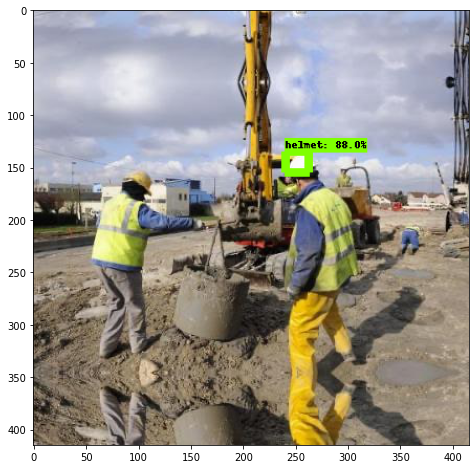

/content/test/helmet_048.jpg


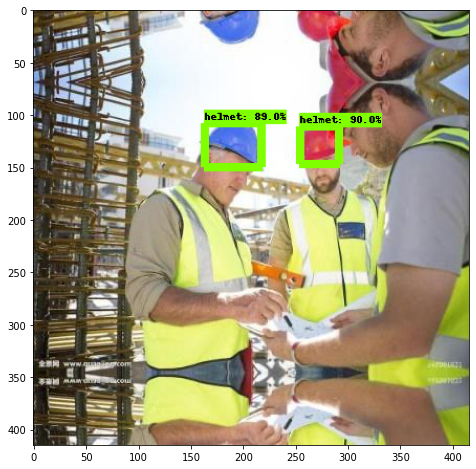

/content/test/helmet_049.jpg


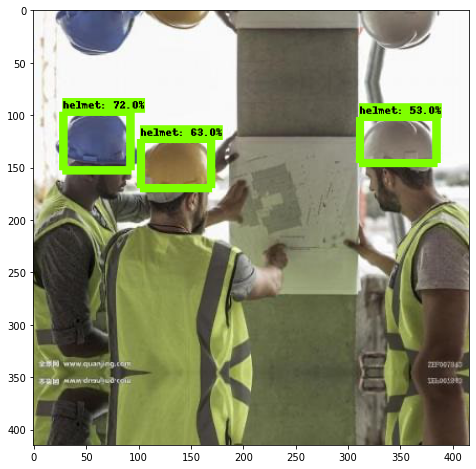

/content/test/helmet_050.jpg


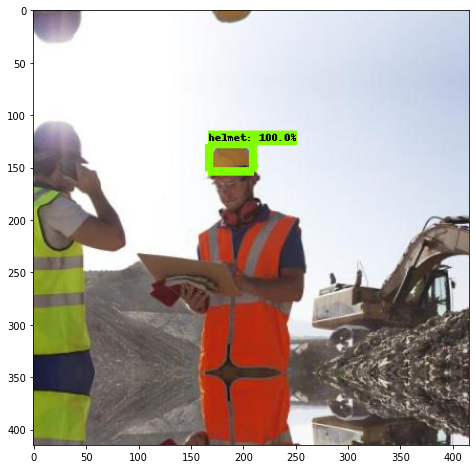

/content/test/helmet_046.jpg


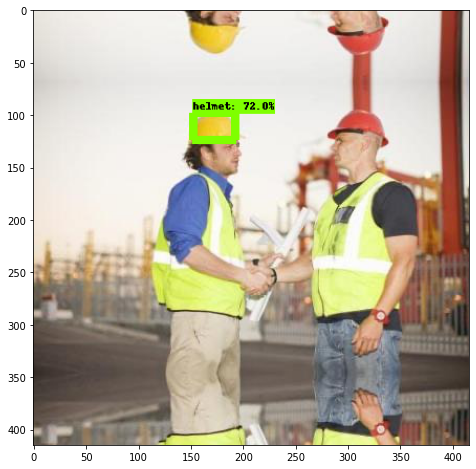

In [32]:
# Visualize the results
%matplotlib inline
plt.close('all')
for image_path in TEST_IMAGE_PATHS[:21]:
  image = Image.open(image_path)
  print(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.show()

# Convert TF model to OpenVINO 21.03 Intermediate Representation (IR)
 This can be used to run inference on OpenVINO.
# In order to run the model on DepthAI modules, we then compile the IR obtained above to a .blob (via a server we set up just for that) 

## First, we install Open Vino 21.03


In [ ]:
%cd ../..

/content/models


In [ ]:
import os
from urllib.parse import urlparse

## install tools. Open Vino takes some time to download - it's ~400MB
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove

## downnload installation files
url = "https://registrationcenter-download.intel.com/akdlm/irc_nas/17662/l_openvino_toolkit_p_2021.3.394.tgz"
!wget {url}

## Get the name of the tgz
parsed = urlparse(url)
openvino_tgz = os.path.basename(parsed.path)
openvino_folder = os.path.splitext(openvino_tgz)[0]

## Extract & install openvino
!tar xf {openvino_tgz}
%cd {openvino_folder}
!./install_openvino_dependencies.sh && \
    sed -i 's/decline/accept/g' silent.cfg && \
    ./install.sh --silent silent.cfg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpci3
Suggested packages:
  libarchive1
The following NEW packages will be installed:
  cpio libpci3 pciutils
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 368 kB of archives.
After this operation, 1,786 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 cpio amd64 2.12+dfsg-6ubuntu0.18.04.4 [86.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpci3 amd64 1:3.5.2-1ubuntu1.1 [24.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 pciutils amd64 1:3.5.2-1ubuntu1.1 [257 kB]
Fetched 368 kB in 0s (4,279 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> lin

In [ ]:
!ls

EULA.txt	install_openvino_dependencies.sh  pset		  rpm
install_GUI.sh	install.sh			  PUBLIC_KEY.PUB  silent.cfg


[Optional] Open Vino install check, generally not needed

In [ ]:
# !source /opt/intel/openvino/bin/setupvars.sh && \
#     /opt/intel/openvino/deployment_tools/demo/demo_squeezenet_download_convert_run.sh

### Here we run some modifications in the ssd2 OpenVINO extension for TF so that our Mobilenet SSDv2 model can convert successfully to the IR

In [ ]:
%cd /opt/intel/openvino_2021/deployment_tools/model_optimizer/extensions/front/tf/

#openvino fixes: edit 
# Read in the file, make sure the .json corresponds to the model!!!
with open('ssd_v2_support.json', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('"Postprocessor/ToFloat"', '"Postprocessor/Cast_1"')

# Write the file out again
with open('ssd_v2_support.json', 'w') as file:
  file.write(filedata)


/opt/intel/openvino_2021.3.394/deployment_tools/model_optimizer/extensions/front/tf


## Convert TF model to Open Vino Intermediate Representation
If using own model, please change to your desired name for output directory --output_dir "choose name"

In [ ]:
#CONVERT TF MODEL to OPEN VINO IRv10. saved in IR_V10_fruits_mnssdv2_6k directory or
#choose own name for --output_dir "choose name"
%cd "/content/models/research/fine_tuned_model/"
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
    python /opt/intel/openvino_2021/deployment_tools/model_optimizer/mo.py \
    --input_model frozen_inference_graph.pb \
    --tensorflow_use_custom_operations_config /opt/intel/openvino_2021/deployment_tools/model_optimizer/extensions/front/tf/ssd_v2_support.json \
    --tensorflow_object_detection_api_pipeline_config pipeline.config \
    --reverse_input_channels \
    --output_dir ./pascal_animals \
    --data_type FP16

/content/models/research/fine_tuned_model
error: XDG_RUNTIME_DIR not set in the environment.
[setupvars.sh] OpenVINO environment initialized
[ WARNING ]  Use of deprecated cli option --tensorflow_use_custom_operations_config detected. Option use in the following releases will be fatal. Please use --transformations_config cli option instead
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/models/research/fine_tuned_model/frozen_inference_graph.pb
	- Path for generated IR: 	/content/models/research/fine_tuned_model/./pascal_animals
	- IR output name: 	frozen_inference_graph
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#check directory containing the exported TF trained model and the IRv10 folder
%ls pascal_animals/

frozen_inference_graph.bin      frozen_inference_graph.xml
frozen_inference_graph.mapping


## Now we compile the IR model to a .blob for use on DepthAI modules/platform

---



### We save the blob in the IR directory from above, corresponding to --output_dir parameter above. 
The blob filename will be *frozen_inference_graph.blob*

In [ ]:
#No changes needed here unless using custom data.
#CHOOSE the directory where you would like to save the blob.
# I use the same --output_dir as above for the IR conversion
blob_dir = "/content/models/research/fine_tuned_model/pascal_animals/"

#Copy the path of your .xml and .bin files. For that, you can look at the IR
#conversion output cell, select and copy from:
#[SUCCESS] XML file and bin file paths.
#Or you can choose to compile other .xml .bin files from a different location
#
xmlfile = "/content/models/research/fine_tuned_model/pascal_animals/frozen_inference_graph.xml"
binfile = "/content/models/research/fine_tuned_model/pascal_animals/frozen_inference_graph.bin"
!python -m pip install blobconverter

import blobconverter
blob_path = blobconverter.from_openvino(
    xml=xmlfile,
    bin=binfile,
    data_type="FP16",
    shaves=5,
)
from google.colab import files
files.download(blob_path) 

     |████████████████████████████████| 131 kB 12.4 MB/s 
     |████████████████████████████████| 8.0 MB 48.5 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 138 kB 50.4 MB/s 
     |████████████████████████████████| 127 kB 52.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires numpy>=1.18.5, but you have numpy 1.17.5 which is incompatible.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.15.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
[==================================================]
Done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Now you can download your .blob file and run it on the DepthAI module/platform
To download locally, use the file explorer on the left to locate the file in the --output_dir folder, then right click download. Colab takes a few seconds to prepare the file, then the download prompt will appear.

# Run the blob on DepthAI

To use this blob with DepthAI:

- Clone depthai demo script

    ```
    $ git clone https://github.com/luxonis/depthai.git
    ```
- Install requirements

    ```
    $ python3 install_requirements.py
    ```
- Create a new model directory and insert the blob

    ```
    $ mkdir resources/nn/custom_mobilenet
    $ mv <downloaded_blob> resources/nn/custom_mobilenet/
    ```

- Copy config file from mobilenet-ssd model

    ```
    $ cp resources/nn/mobilenet-ssd/mobilenet-ssd.json resources/nn/custom_mobilenet/custom_mobilenet.json
    ```

- Run the demo script

    ```
    $ python3 depthai_demo.py -cnn custom_mobilenet
    ```

You can read more details on deployment [here](https://docs.luxonis.com/en/latest/pages/tutorials/first_steps/#using-custom-models)


In [ ]:
#Compress the folder with the Tensorflow model and OpenVINO IR_V10 folder and download it locally.
#These are in content/models/research/fine_tuned_model, so we compress the fine_tuned_model folder.
!tar czvf fine_tuned_model.tar.gz {blob_dir}


tar: Removing leading `/' from member names
/content/models/research/fine_tuned_model/pascal_animals/
/content/models/research/fine_tuned_model/pascal_animals/frozen_inference_graph.bin
/content/models/research/fine_tuned_model/pascal_animals/frozen_inference_graph.mapping
/content/models/research/fine_tuned_model/pascal_animals/frozen_inference_graph.xml


In [ ]:
#download the compressed IRv10 folder locally
#or can use file navigator on the left to move it to your gdrive
from google.colab import files
files.download("fine_tuned_model.tar.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>